In [21]:

import os
import cv2
import numpy as np
import pandas as pd
import keras as keras
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img,img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
dir = '/kaggle/input/leapgestrecog/leapGestRecog'

In [3]:
images = []
labels = []

for directory in os.listdir(dir):
    for subdir in os.listdir(os.path.join(dir,directory)):
        for img in os.listdir(os.path.join(dir,directory,subdir)):
            img_path = os.path.join(dir, directory, subdir, img)
            images.append(img_path)
            labels.append(subdir)

In [4]:
img_series = pd.Series(images, name='Images')
lab_series = pd.Series(labels, name='labels')

data = pd.concat([img_series, lab_series], axis = 1)
df = pd.DataFrame(data)

In [5]:
df.head()

,Images,labels
0,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,02_l
1,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,02_l
2,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,02_l
3,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,02_l
4,/kaggle/input/leapgestrecog/leapGestRecog/07/0...,02_l


In [6]:
image_shape = cv2.imread('/kaggle/input/leapgestrecog/leapGestRecog/05/07_ok/frame_05_07_0009.png')
print(image_shape.shape)

(240, 640, 3)


In [7]:
pd.Series(labels).value_counts()

02_l             2000
04_fist_moved    2000
09_c             2000
10_down          2000
06_index         2000
08_palm_moved    2000
07_ok            2000
05_thumb         2000
01_palm          2000
03_fist          2000
Name: count, dtype: int64

In [10]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
train_set, valid_set = train_test_split(df, test_size=0.3, random_state=42)

In [11]:
img_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train = img_gen.flow_from_dataframe(dataframe= train_set,x_col="Images",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=4,
                                      shuffle=False
                                     )

test = img_gen.flow_from_dataframe(dataframe= X_test,x_col="Images", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
valid = img_gen.flow_from_dataframe(dataframe= valid_set,x_col="Images", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 14000 validated image filenames belonging to 10 classes.
Found 4000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.


In [12]:
classes = list(train.class_indices.keys())
classes

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [13]:
input_shape = (244, 244, 3)
num_classes = 10

In [14]:
inputs = Input(shape=input_shape)

x = Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu')(inputs)
x = BatchNormalization()(x)

x = Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3))(x)

x = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)

x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same")(x)
x = BatchNormalization()(x)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(num_classes, activation='softmax')(x)

In [15]:
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 79, 79, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 79, 79, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 79, 79, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 79, 79, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 26, 26, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 13, 13, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 13, 13, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 13, 13, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,80

 Total params: 15,617,674 (59.58 MB)

 Trainable params: 15,611,274 (59.55 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [16]:
history = model.fit(train, epochs=3, validation_data=valid, verbose=1)

Epoch 1/3


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   3/3500 ━━━━━━━━━━━━━━━━━━━━ 2:26 42ms/step - accuracy: 0.1806 - loss: 3.6045   

I0000 00:00:1715741688.610981      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715741688.640054      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3499/3500 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6143 - loss: 1.3133

W0000 00:00:1715741836.082376      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3500/3500 ━━━━━━━━━━━━━━━━━━━━ 225s 60ms/step - accuracy: 0.6145 - loss: 1.3128 - val_accuracy: 0.9983 - val_loss: 0.0055
Epoch 2/3
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 119s 34ms/step - accuracy: 0.9928 - loss: 0.0304 - val_accuracy: 0.9998 - val_loss: 0.0012
Epoch 3/3
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 120s 34ms/step - accuracy: 0.9978 - loss: 0.0099 - val_accuracy: 0.9995 - val_loss: 0.0011


In [17]:
model.evaluate(test, verbose=1)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9994 - loss: 0.0014


[0.001258369185961783, 0.9994999766349792]

In [18]:
model.save('model.h5')

In [19]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

  13/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step

W0000 00:00:1715742998.583958      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step


In [20]:
y_test = X_test.labels
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       410
         02_l       1.00      1.00      1.00       417
      03_fist       0.99      1.00      1.00       366
04_fist_moved       1.00      1.00      1.00       404
     05_thumb       1.00      1.00      1.00       409
     06_index       1.00      1.00      1.00       377
        07_ok       1.00      1.00      1.00       403
08_palm_moved       1.00      1.00      1.00       392
         09_c       1.00      1.00      1.00       404
      10_down       1.00      1.00      1.00       418

     accuracy                           1.00      4000
    macro avg       1.00      1.00      1.00      4000
 weighted avg       1.00      1.00      1.00      4000

Accuracy of the Model: 100.0%


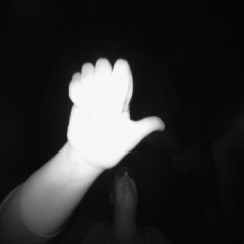

In [35]:
img1 = load_img("/kaggle/input/leapgestrecog/leapGestRecog/05/05_thumb/frame_05_05_0027.png",target_size=(244,244,3))
img1

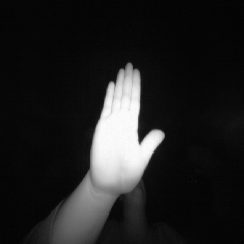

In [34]:
img2 = load_img("/kaggle/input/leapgestrecog/leapGestRecog/05/01_palm/frame_05_01_0012.png",target_size=(244,244,3))
img2

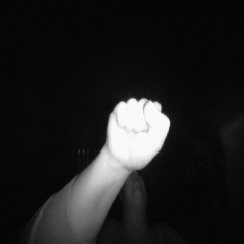

In [30]:
img3 = load_img("/kaggle/input/leapgestrecog/leapGestRecog/05/03_fist/frame_05_03_0012.png",target_size=(244,244,3))
img3

In [36]:
img1 = img_to_array(img1)
img1 = img1 / 255.0 
img1 = np.expand_dims(img1, axis=0)


img2 = img_to_array(img2)
img2 = img2 / 255.0 
img2 = np.expand_dims(img2, axis=0) 


img3 = img_to_array(img3)
img3 = img3 / 255.0 
img3 = np.expand_dims(img3, axis=0) 

p1 = model.predict(img1).argmax()
p2 = model.predict(img2).argmax()
p3 = model.predict(img3).argmax()

print("Class for Image 1:", p1)
print("Class for Image 2:", p2)
print("Class for Image 3:", p3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class for Image 1: 1
Class for Image 2: 1
Class for Image 3: 5
